<a href="https://colab.research.google.com/github/abdullahakram07/Supervised_Relation_extraction/blob/main/Relation_extraction_with_LukeForEntityPairClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we are going to fine-tune [`LukeForEntityPairClassification`](https://huggingface.co/transformers/model_doc/luke.html#lukeforentitypairclassification) on a supervised **relation extraction** TACRED dataset.

In [ ]:
!pip install -q transformers

In [ ]:
!pip install -q pytorch-lightning wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 777.7/777.7 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 48.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 52.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.6 MB/s eta 0:00:00


## Read in data

Let's download the data from the web, hosted on Dropbox.

In [ ]:
import requests, zipfile, io

def download_data():
    url = "https://www.dropbox.com/s/izi2x4sjohpzoot/relation_extraction_dataset.zip?dl=1"
    r = requests.get(url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall()

download_data()

Each row in the dataframe consists of a news article, and a sentence in which a certain relationship was found (just as "invested_in", or "founded_by"). There were some patterns used to gather the data, so it might contain some noise.

In [ ]:
import pandas as pd

df = pd.read_pickle("relation_extraction_dataset.pkl")
df.reset_index(drop=True, inplace=True)
df.head()

,end_idx,entities,entity_spans,match,original_article,sentence,start_idx,string_id
0,1024,"[Lilium, Baillie Gifford]","[[3, 9], [151, 166]]",raising $35,Happy Friday!\n\nWe sincerely hope you and you...,"3) Lilium, a German startup that’s making an a...",1013,invested_in
1,1762,"[Facebook ’s, Giphy]","[[92, 102], [148, 153]]",acquisition,Happy Friday!\n\nWe sincerely hope you and you...,"Meanwhile, the UK’s watchdog on Friday announc...",1751,acquired_by
2,2784,"[Global-e, Vitruvian Partners]","[[27, 35], [94, 112]]",raised $60,Happy Friday!\n\nWe sincerely hope you and you...,Israeli e-commerce startup Global-e has raised...,2774,invested_in
3,680,"[Joris Van Der Gucht, Silverfin]","[[0, 19], [35, 44]]",founder,Hg is a leading investor in tax and accounting...,"Joris Van Der Gucht, co-founder at Silverfin c...",673,founded_by
4,2070,"[Tim Vandecasteele, Silverfin]","[[0, 17], [71, 80]]",founder,Hg is a leading investor in tax and accounting...,"Tim Vandecasteele, co-founder added: ""We want ...",2063,founded_by


Let's create 2 dictionaries, one that maps each label to a unique integer, and one that does it the other way around.

In [ ]:
id2label = dict()
for idx, label in enumerate(df.string_id.value_counts().index):
  id2label[idx] = label

As we can see, there are 7 labels (7 unique relationships):

In [ ]:
id2label

{0: 'founded_by',
 1: 'acquired_by',
 2: 'invested_in',
 3: 'CEO_of',
 4: 'subsidiary_of',
 5: 'partners_with',
 6: 'owned_by'}

In [ ]:
label2id = {v:k for k,v in id2label.items()}
label2id

{'founded_by': 0,
 'acquired_by': 1,
 'invested_in': 2,
 'CEO_of': 3,
 'subsidiary_of': 4,
 'partners_with': 5,
 'owned_by': 6}

In [ ]:
df.shape

(12031, 8)

## Define the PyTorch dataset and dataloaders


PyTorch datasets and dataloaders for relation extraction using the LUKE model. It involves defining a Dataset class, implementing key methods, and utilizing the LukeTokenizer from Transformers. Dataset items, containing sentence, entity spans, and labels, are converted to model inputs, such as input_ids and attention_mask. Details are in the LUKE documentation here.

For more information regarding these inputs, refer to the [docs](https://huggingface.co/transformers/model_doc/luke.html#lukeforentitypairclassification) of `LukeForEntityPairClassification`.


In [ ]:
from transformers import LukeTokenizer
from torch.utils.data import Dataset, DataLoader
import torch

tokenizer = LukeTokenizer.from_pretrained("studio-ousia/luke-base", task="entity_pair_classification")

class RelationExtractionDataset(Dataset):
    """Relation extraction dataset."""

    def __init__(self, data):
        """
        Args:
            data : Pandas dataframe.
        """
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data.iloc[idx]

        sentence = item.sentence
        entity_spans = [tuple(x) for x in item.entity_spans]

        encoding = tokenizer(sentence, entity_spans=entity_spans, padding="max_length", truncation=True, return_tensors="pt")

        for k,v in encoding.items():
          encoding[k] = encoding[k].squeeze()

        encoding["label"] = torch.tensor(label2id[item.string_id])

        return encoding

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.04k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

entity_vocab.json:   0%|          | 0.00/15.3M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/33.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/836 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Here we instantiate the class defined above with 3 objects: a training dataset, a validation dataset and a test set.

In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42, shuffle=False)

# define the dataset
train_dataset = RelationExtractionDataset(data=train_df)
valid_dataset = RelationExtractionDataset(data=val_df)
test_dataset = RelationExtractionDataset(data=test_df)

In [ ]:
train_dataset[0].keys()

dict_keys(['input_ids', 'entity_ids', 'entity_position_ids', 'attention_mask', 'entity_attention_mask', 'label'])

Let's define the corresponding dataloaders (which allow us to iterate over the elements of the dataset):

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=2)
test_dataloader = DataLoader(test_dataset, batch_size=2)

Let's verify an example of a batch:

In [ ]:
batch = next(iter(train_dataloader))
tokenizer.decode(batch["input_ids"][1])

'<s>had expected 564 3 million Symantec has been struggling with severe competition from nimbler rivals and sources had told <ent>  Reuters <ent>  last month that it walked away from negotiations to sell the entire company to <ent2>  Broadcom <ent2>  over price disagreements</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><

In [ ]:
id2label[batch["label"][1].item()]

'acquired_by'

## Define a PyTorch LightningModule

Let's define the model as a PyTorch LightningModule. A `LightningModule` is actually an `nn.Module`, but with some extra functionality.

For more information regarding how to define this, see the [docs](https://pytorch-lightning.readthedocs.io/en/latest/?_ga=2.56317931.1395871250.1622709933-1738348008.1615553774) of PyTorch Lightning.

In [ ]:
from transformers import LukeForEntityPairClassification, AdamW
import pytorch_lightning as pl

class LUKE(pl.LightningModule):

    def __init__(self):
        super().__init__()
        self.model = LukeForEntityPairClassification.from_pretrained("studio-ousia/luke-base", num_labels=len(label2id))

    def forward(self, input_ids, entity_ids, entity_position_ids, attention_mask, entity_attention_mask):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask, entity_ids=entity_ids,
                             entity_attention_mask=entity_attention_mask, entity_position_ids=entity_position_ids)
        return outputs

    def common_step(self, batch, batch_idx):
        labels = batch['label']
        del batch['label']
        outputs = self(**batch)
        logits = outputs.logits

        criterion = torch.nn.CrossEntropyLoss() # multi-class classification
        loss = criterion(logits, labels)
        predictions = logits.argmax(-1)
        correct = (predictions == labels).sum().item()
        accuracy = correct/batch['input_ids'].shape[0]

        return loss, accuracy

    def training_step(self, batch, batch_idx):
        loss, accuracy = self.common_step(batch, batch_idx)
        # logs metrics for each training_step,
        # and the average across the epoch
        self.log("training_loss", loss)
        self.log("training_accuracy", accuracy)

        return loss

    def validation_step(self, batch, batch_idx):
        loss, accuracy = self.common_step(batch, batch_idx)
        self.log("validation_loss", loss, on_epoch=True)
        self.log("validation_accuracy", accuracy, on_epoch=True)

        return loss

    def test_step(self, batch, batch_idx):
        loss, accuracy = self.common_step(batch, batch_idx)

        return loss

    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), lr=5e-5)
        return optimizer

    def train_dataloader(self):
        return train_dataloader

    def val_dataloader(self):
        return valid_dataloader

    def test_dataloader(self):
        return test_dataloader

Let's verify a forward pass on a batch:

In [ ]:
batch = next(iter(valid_dataloader))
labels = batch["label"]
batch.keys()

dict_keys(['input_ids', 'entity_ids', 'entity_position_ids', 'attention_mask', 'entity_attention_mask', 'label'])

In [ ]:
batch["input_ids"].shape

torch.Size([2, 512])

In [ ]:
model = LUKE()
del batch["label"]
outputs = model(**batch)

pytorch_model.bin:   0%|          | 0.00/1.10G [00:00<?, ?B/s]

Some weights of LukeForEntityPairClassification were not initialized from the model checkpoint at studio-ousia/luke-base and are newly initialized: ['classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The initial loss should be around -ln(1/number of classes) = -ln(1/7) = 1.95:

In [ ]:
criterion = torch.nn.CrossEntropyLoss()

initial_loss = criterion(outputs.logits, labels)
print("Initial loss:", initial_loss)

Initial loss: tensor(1.9037, grad_fn=<NllLossBackward0>)


## Train the model

Let's train the model. We also use early stopping, to avoid overfitting the training dataset. We also log everything to Weights and Biases, which will give us beautiful charts of the loss and accuracy plotted over time.

If you haven't already, you can create an account on the [website](https://wandb.ai/site), then log in in a web browser, and run the cell below:

In [ ]:
import wandb

wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import EarlyStopping

wandb_logger = WandbLogger(name='luke-first-run-12000-articles-bis', project='LUKE')
# for early stopping, see https://pytorch-lightning.readthedocs.io/en/1.0.0/early_stopping.html?highlight=early%20stopping
early_stop_callback = EarlyStopping(
    monitor='val_loss',
    patience=2,
    strict=False,
    verbose=False,
    mode='min'
)

trainer = Trainer(logger=wandb_logger, callbacks=[EarlyStopping(monitor='validation_loss')])
trainer.fit(model)

In [ ]:
trainer.test()

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:145: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at ./LUKE/5y85go9i/checkpoints/epoch=3-step=7700.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at ./LUKE/5y85go9i/checkpoints/epoch=3-step=7700.ckpt
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in th

Testing: |          | 0/? [00:00<?, ?it/s]

[{}]

## Evaluation

Instead of calling `trainer.test()`, we can also manually evaluate the model on the entire test set:

In [ ]:
!pip install gdown

# The Google Drive link for the trained_model
file_id = '1nL7EEHLbiuFHt7NX_Q-Zf1gS4jgc6cuq'
output_path = '/content/checkpoint.ckpt'

# Download the file using gdown
!gdown --id $file_id --output $output_path

# Load the model from the downloaded checkpoint
# Note: If you train model by yourself then please change the checkpoint_path with path of updated weights
loaded_model = LUKE.load_from_checkpoint(checkpoint_path=output_path)

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:138: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1nL7EEHLbiuFHt7NX_Q-Zf1gS4jgc6cuq
From (redirected): https://drive.google.com/uc?id=1nL7EEHLbiuFHt7NX_Q-Zf1gS4jgc6cuq&confirm=t&uuid=626d53e5-beac-4d0b-83df-a7b01471ebb3
To: /content/checkpoint.ckpt
100% 3.29G/3.29G [00:24<00:00, 136MB/s] 


Some weights of LukeForEntityPairClassification were not initialized from the model checkpoint at studio-ousia/luke-base and are newly initialized: ['classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score

loaded_model.model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loaded_model.to(device)

predictions_total = []
labels_total = []
for batch in tqdm(test_dataloader):
    # get the inputs;
    labels = batch["label"]
    del batch["label"]

    # move everything to the GPU
    for k,v in batch.items():
      batch[k] = batch[k].to(device)

    # forward pass
    outputs = loaded_model.model(**batch)
    logits = outputs.logits
    predictions = logits.argmax(-1)
    predictions_total.extend(predictions.tolist())
    labels_total.extend(labels.tolist())

  0%|          | 0/1204 [00:00<?, ?it/s]

In [ ]:
print("Accuracy on test set:", accuracy_score(labels_total, predictions_total))

Accuracy on test set: 0.9389281262982966


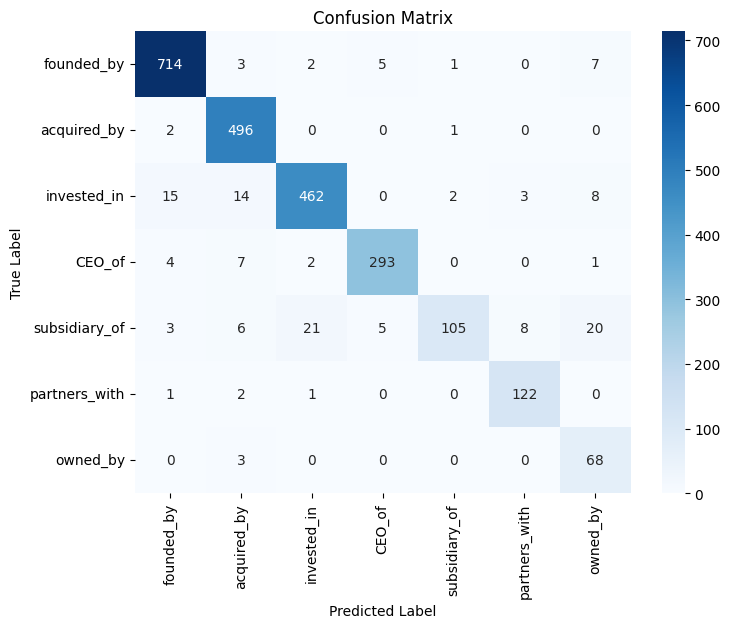

Classification Report:
               precision    recall  f1-score   support

   founded_by       0.97      0.98      0.97       732
  acquired_by       0.93      0.99      0.96       499
  invested_in       0.95      0.92      0.93       504
       CEO_of       0.97      0.95      0.96       307
subsidiary_of       0.96      0.62      0.76       168
partners_with       0.92      0.97      0.94       126
     owned_by       0.65      0.96      0.78        71

     accuracy                           0.94      2407
    macro avg       0.91      0.91      0.90      2407
 weighted avg       0.94      0.94      0.94      2407

Precision: 0.9435805769947277
Recall: 0.9389281262982966
F1 Score: 0.9376028223897241


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix
confusion_mat = confusion_matrix(labels_total, predictions_total)

# Visualization of Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues", xticklabels=label2id.keys(), yticklabels=label2id.keys())
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(labels_total, predictions_total, target_names=label2id.keys()))

# Other Evaluation Metrics
precision = precision_score(labels_total, predictions_total, average='weighted')
recall = recall_score(labels_total, predictions_total, average='weighted')
f1 = f1_score(labels_total, predictions_total, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

## Inference

Here we test the trained model on a new, unseen sentence.

In [ ]:
test_df.iloc[0].sentence

'Roxanne also co-founded StartHer'

In [ ]:
import torch.nn.functional as F

idx = 55
text = test_df.iloc[idx].sentence
entity_spans = test_df.iloc[idx].entity_spans  # character-based entity spans
entity_spans = [tuple(x) for x in entity_spans]

inputs = tokenizer(text, entity_spans=entity_spans, return_tensors="pt")

# Move input tensors to the same device as the model
inputs = {key: value.to(device) for key, value in inputs.items()}

# Ensure the model is also on the same device
loaded_model.to(device)

# Forward pass
outputs = loaded_model.model(**inputs)
logits = outputs.logits
predicted_class_idx = logits.argmax(-1).item()

print("Sentence:", text)
print("Ground truth label:", test_df.iloc[idx].string_id)
print("Predicted class idx:", id2label[predicted_class_idx])
print("Confidence:", F.softmax(logits, -1).max().item())

Sentence: While luminaries like Mila founder Yoshua Bengio and Facebook VP and chief AI scientist Yann LeCun argue that AGI can t exist OpenAI s cofounders and backers among them
Ground truth label: founded_by
Predicted class idx: founded_by
Confidence: 0.9901642203330994
